In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from skimage import io
import numpy as np
from scipy.spatial import Delaunay
import networkx as nx
import matplotlib.pyplot as plt
import voronoi
import misc
from misc import show_img
import prop

import scipy.ndimage as ndi

import ground_truth_perturbation as gtp

import geometric_graph
import networkx.drawing as draw

In [2]:
# Parameters
minEdgeWidth = 1
maxEdgeWidth = 10

radius = 350   # Distânce to connect galnds
isGeometricGraph = True

isHealth = True
isMount = True

alpha = 1
edge_alpha = 0.15

iterat = 0 #22

range_to_remove = [] #np.arange(0.76, .99, 0.02)

shape_props_to_measure = ['area', 'solidity', 'eccentricity', 'equivalent_diameter', 'perimeter']


In [3]:
# Define data paths
erode_root_img_path = []
dilate_root_img_path = []
dilate_no_merge_root_img_path = []

for i in range(1, iterat, 2):
    erode_root_img_path.append('prostate_marked/S07_46186 10X_20151028_59_EROSION_IT' + str(i))
    dilate_root_img_path.append('prostate_marked/S07_46186 10X_20151028_59_DILATION_IT' + str(i))
    dilate_no_merge_root_img_path.append('prostate_marked/S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT' + str(i))

remove_randoly_root_img_path = []

for i in range_to_remove:
    remove_randoly_root_img_path.append('prostate_marked/S07_46186 10X_20151028_59_RANDOMLY_REMOVE_' + str(int(i*100)))
    
#article_root_img_path = ['prostate_marked/S07_46186 10X_20151028_59', 
#                         'prostate_marked/3']

article_rev1_root_img_path = ['prostate_marked/3', 
                              'prostate_marked/S07_40805_upper_10X_Snapshot_20151028_54_region_01', 
                              'prostate_marked/S07_40805_upper_10X_Snapshot_20151028_54_region_11',
                              'prostate_marked/S07_41755_lower_10X_Snapshot_20151028_45_region_09',
                              'prostate_marked/S07_41755_lower_10X_Snapshot_20151028_45_region_10',
                              'prostate_marked/S07_41755_lower_10X_Snapshot_20151028_45_region_15',
                              'prostate_marked/S07_41755_upper_10X_Snapshot_20151028_44_region_02', 
                              'prostate_marked/S07_41755_upper_10X_Snapshot_20151028_44_region_03', 
                              'prostate_marked/S07_41755_upper_10X_Snapshot_20151028_44_region_04', 
                              'prostate_marked/S07_41755_upper_10X_Snapshot_20151028_44_region_13',
                              'prostate_marked/S07_42991_lower_10X_Snapshot_20151028_47_region_08', 
                              'prostate_marked/S07_42991_lower_10X_Snapshot_20151028_47_region_14',
                              'prostate_marked/S07_46186 10X_20151028_59'
                            ]

In [4]:
class gland_property():
    img = None, False, -1, None, None, None, None, None, None, None

    def __init__(self, _id, _row, _column, _area, _demarcated, _solidity, _eccentricity, _equivalent_diameter, _perimeter, _degree, _strength, _betweenness):
        #identification
        self.id = _id,
        self.row = _row,
        self.column = _column,
        self.demarcated = _demarcated
        #shape measures
        self.area = _area, 
        self.solidity = _solidity,
        self.eccentricity = _eccentricity,
        self.equivalent_diameter = _equivalent_diameter,
        self.perimeter = _perimeter,
        
        #net properties
        self.degree = _degree
        self.strength = _strength
        self.betweenness = _betweenness

# Erode

In [ ]:
pos_path = 0
for i in range(1, iterat, 2):
    root_img_path = erode_root_img_path[pos_path]

    result_path = root_img_path + '/results_radius_' + str(radius)
    
    img_path = root_img_path + '/IMG.jpg'
    img_mask_path = root_img_path + '/MASK.jpg'
    img_expert_demarcation_path = root_img_path + '/CA MASK.jpg'
    
    img = io.imread(img_path)
    img_mask = io.imread(img_mask_path)
    img_mask = misc.mask_correction(img_mask)
    expert_demarcation = io.imread(img_expert_demarcation_path)
    expert_demarcation = misc.mask_correction(expert_demarcation)
    
    img_mask = ndi.binary_erosion(img_mask, iterations=i, structure=[[0,1,0],[1,1,1],[0,1,0]])
    path_img_mask_modified = root_img_path + "/MASK EROSION " + str(i) + ".png"
    
    fig = plt.figure(figsize=(28,24) , dpi=150)
    plt.axes([0,0,1,1])
    plt.axis('off')
    plt.imshow(255-img_mask, cmap='gray')
    plt.savefig(path_img_mask_modified, dpi=300)
    
    img_label, n = ndi.label(img_mask)
    img_expert_label, n_expert = ndi.label(expert_demarcation)
    print('Glands: ' + str(n) + ' - Region Demarcated: ' + str(n_expert))

    if not((img.shape[0], img.shape[1]) == img_mask.shape == expert_demarcation.shape):
        raise Exception('Images must have the same size')
    
    
    shape_props, props = prop.get_shape_props_from_mask(img_mask, shape_props_to_measure, return_scikit_props=True)
    
    g, points = geometric_graph.network_from_mask(img_mask, radius)
    nxgraph = misc.igraph_to_nx(g)
    g.vs['pos'] = points.tolist()

    fig = plt.figure(figsize=(40,15))
    ax = plt.subplot(111, aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    
    draw.draw_networkx(nxgraph, points, node_size=20, with_labels=False, edge_alpha=edge_alpha)

    nxgraph = misc.igraph_to_nx(g)
    nx.write_gml(nxgraph, result_path + "/grafo_" + str(radius) + "r.gml")
    plt.savefig(result_path + "/grafo_" + str(radius) + "r.png")
    
    
    ###############
    #Network Properties
    pos_nodes = g.vs["pos"]
    
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=None, normalize_pos=True, 
                                            normalize_att=True, alpha=alpha)

    nx.set_edge_attributes(nxgraph, weight_dict, 'weight')
    net_props = prop.get_graph_props(nxgraph)

    gland_properties  = []
    count = 0

    for idx in range(len(shape_props)):
        position = list(map(int, props[idx].centroid))
        
        obj = gland_property(_id = count, _row=int(position[0]), _column=int(position[1]), _demarcated=(expert_demarcation[position[0]][position[1]]==255), _area=shape_props[idx][0], _solidity=shape_props[idx][1], _eccentricity=shape_props[idx][2], _equivalent_diameter=shape_props[idx][3], _perimeter=shape_props[idx][4], _degree=net_props[idx][0], _strength=net_props[idx][1], _betweenness=net_props[idx][2])
        gland_properties.append(obj)
        
        count = count + 1

    demarcated_quantity_ = [(t.row[0],t.column[0]) for t in gland_properties if t.demarcated == True]
    print('Glands in Demarcated Area: ' + str(len(demarcated_quantity_)))        

    with open(result_path + '/glands_properties_' + str(radius) +'r.txt', 'w') as f:
        f.write('idx, row, column, demarcated, area, solidity, eccentricity, equivalent_diameter, perimeter, degree, strength, betweenness\n')
        for item in gland_properties:
            f.write("%d, %d, %d, %s, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f\n" % (item.id[0], item.row[0], item.column[0], item.demarcated, item.area[0], item.solidity[0], item.eccentricity[0], item.equivalent_diameter[0], item.perimeter[0], item.degree, item.strength, item.betweenness))

    nxgraph_properties = nxgraph = nx.Graph(nxgraph)

    id_dict = {}
    row_dict = {}
    column_dict = {}
    demarcated_dict ={}
    area_dict = {}
    solidity_dict = {}
    eccentricity_dict = {}
    equivalent_diameter_dict = {}
    perimeter_dict = {}
    degree_dict = {}
    strength_dict = {}
    betweenness_dict = {}

    for t in gland_properties:
        id_dict[t.id[0]] = t.id[0]
        row_dict[t.id[0]] = t.row[0]
        column_dict[t.id[0]] = t.column[0]
        demarcated_dict[t.id[0]] = str(t.demarcated)
        area_dict[t.id[0]] = t.area[0]
        solidity_dict[t.id[0]] = t.solidity[0]
        eccentricity_dict[t.id[0]] = t.eccentricity[0]
        equivalent_diameter_dict[t.id[0]] = t.equivalent_diameter[0]
        perimeter_dict[t.id[0]] = t.perimeter[0]
        degree_dict[t.id[0]] = t.degree
        strength_dict[t.id[0]] = t.strength
        betweenness_dict[t.id[0]] = t.betweenness
    
    nx.set_node_attributes(nxgraph, id_dict, 'idx')
    nx.set_node_attributes(nxgraph, row_dict, 'row')
    nx.set_node_attributes(nxgraph, column_dict, 'column')
    nx.set_node_attributes(nxgraph, demarcated_dict, 'demarcated')
    nx.set_node_attributes(nxgraph, area_dict, 'area')
    nx.set_node_attributes(nxgraph, solidity_dict, 'solidity')
    nx.set_node_attributes(nxgraph, eccentricity_dict, 'eccentricity')
    nx.set_node_attributes(nxgraph, equivalent_diameter_dict, 'diameter')
    nx.set_node_attributes(nxgraph, perimeter_dict, 'perimeter')
    nx.set_node_attributes(nxgraph, degree_dict, 'degree')
    nx.set_node_attributes(nxgraph, strength_dict, 'strength')
    nx.set_node_attributes(nxgraph, betweenness_dict, 'betweenness')

    nx.write_gml(nxgraph_properties, result_path + "/grafo_glands_properties_" + str(radius) + "r.gml")

    ###############
    
    pos_path += 1

# # Dilate

In [ ]:
pos_path = 0
for i in range(1, iterat, 2):
    root_img_path = dilate_root_img_path[pos_path]

    result_path = root_img_path + '/results_radius_' + str(radius)
    
    img_path = root_img_path + '/IMG.jpg'
    img_mask_path = root_img_path + '/MASK.jpg'
    img_expert_demarcation_path = root_img_path + '/CA MASK.jpg'
    
    img = io.imread(img_path)
    img_mask = io.imread(img_mask_path)
    img_mask = misc.mask_correction(img_mask)
    expert_demarcation = io.imread(img_expert_demarcation_path)
    expert_demarcation = misc.mask_correction(expert_demarcation)
    
    img_mask = ndi.binary_dilation(img_mask, iterations=i, structure=[[0,1,0],[1,1,1],[0,1,0]])
    path_img_mask_modified = root_img_path + "/MASK DILATION " + str(i) + ".png"
    
    fig = plt.figure(figsize=(28,24) , dpi=150)
    plt.axes([0,0,1,1])
    plt.axis('off')
    plt.imshow(255-img_mask, cmap='gray')
    plt.savefig(path_img_mask_modified, dpi=300)
    
    img_label, n = ndi.label(img_mask)
    img_expert_label, n_expert = ndi.label(expert_demarcation)
    print('Glands: ' + str(n) + ' - Region Demarcated: ' + str(n_expert))

    if not((img.shape[0], img.shape[1]) == img_mask.shape == expert_demarcation.shape):
        raise Exception('Images must have the same size')
    
    
    shape_props, props = prop.get_shape_props_from_mask(img_mask, shape_props_to_measure, return_scikit_props=True)
    
    g, points = geometric_graph.network_from_mask(img_mask, radius)
    nxgraph = misc.igraph_to_nx(g)
    g.vs['pos'] = points.tolist()

    fig = plt.figure(figsize=(40,15))
    ax = plt.subplot(111, aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    
    draw.draw_networkx(nxgraph, points, node_size=20, with_labels=False, edge_alpha=edge_alpha)

    nxgraph = misc.igraph_to_nx(g)
    nx.write_gml(nxgraph, result_path + "/grafo_" + str(radius) + "r.gml")
    plt.savefig(result_path + "/grafo_" + str(radius) + "r.png")
    
    
    ###############
    #Network Properties
    pos_nodes = g.vs["pos"]
    
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=None, normalize_pos=True, 
                                            normalize_att=True, alpha=alpha)

    nx.set_edge_attributes(nxgraph, weight_dict, 'weight')
    net_props = prop.get_graph_props(nxgraph)

    gland_properties  = []
    count = 0

    for idx in range(len(shape_props)):
        position = list(map(int, props[idx].centroid))
        
        obj = gland_property(_id = count, _row=int(position[0]), _column=int(position[1]), _demarcated=(expert_demarcation[position[0]][position[1]]==255), _area=shape_props[idx][0], _solidity=shape_props[idx][1], _eccentricity=shape_props[idx][2], _equivalent_diameter=shape_props[idx][3], _perimeter=shape_props[idx][4], _degree=net_props[idx][0], _strength=net_props[idx][1], _betweenness=net_props[idx][2])
        gland_properties.append(obj)
        
        count = count + 1

    demarcated_quantity_ = [(t.row[0],t.column[0]) for t in gland_properties if t.demarcated == True]
    print('Glands in Demarcated Area: ' + str(len(demarcated_quantity_)))        

    with open(result_path + '/glands_properties_' + str(radius) +'r.txt', 'w') as f:
        f.write('idx, row, column, demarcated, area, solidity, eccentricity, equivalent_diameter, perimeter, degree, strength, betweenness\n')
        for item in gland_properties:
            f.write("%d, %d, %d, %s, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f\n" % (item.id[0], item.row[0], item.column[0], item.demarcated, item.area[0], item.solidity[0], item.eccentricity[0], item.equivalent_diameter[0], item.perimeter[0], item.degree, item.strength, item.betweenness))

    nxgraph_properties = nxgraph = nx.Graph(nxgraph)

    id_dict = {}
    row_dict = {}
    column_dict = {}
    demarcated_dict ={}
    area_dict = {}
    solidity_dict = {}
    eccentricity_dict = {}
    equivalent_diameter_dict = {}
    perimeter_dict = {}
    degree_dict = {}
    strength_dict = {}
    betweenness_dict = {}

    for t in gland_properties:
        id_dict[t.id[0]] = t.id[0]
        row_dict[t.id[0]] = t.row[0]
        column_dict[t.id[0]] = t.column[0]
        demarcated_dict[t.id[0]] = str(t.demarcated)
        area_dict[t.id[0]] = t.area[0]
        solidity_dict[t.id[0]] = t.solidity[0]
        eccentricity_dict[t.id[0]] = t.eccentricity[0]
        equivalent_diameter_dict[t.id[0]] = t.equivalent_diameter[0]
        perimeter_dict[t.id[0]] = t.perimeter[0]
        degree_dict[t.id[0]] = t.degree
        strength_dict[t.id[0]] = t.strength
        betweenness_dict[t.id[0]] = t.betweenness
    
    nx.set_node_attributes(nxgraph, id_dict, 'idx')
    nx.set_node_attributes(nxgraph, row_dict, 'row')
    nx.set_node_attributes(nxgraph, column_dict, 'column')
    nx.set_node_attributes(nxgraph, demarcated_dict, 'demarcated')
    nx.set_node_attributes(nxgraph, area_dict, 'area')
    nx.set_node_attributes(nxgraph, solidity_dict, 'solidity')
    nx.set_node_attributes(nxgraph, eccentricity_dict, 'eccentricity')
    nx.set_node_attributes(nxgraph, equivalent_diameter_dict, 'diameter')
    nx.set_node_attributes(nxgraph, perimeter_dict, 'perimeter')
    nx.set_node_attributes(nxgraph, degree_dict, 'degree')
    nx.set_node_attributes(nxgraph, strength_dict, 'strength')
    nx.set_node_attributes(nxgraph, betweenness_dict, 'betweenness')

    nx.write_gml(nxgraph_properties, result_path + "/grafo_glands_properties_" + str(radius) + "r.gml")

    ###############
    
    pos_path += 1

# # Dilation No Merge

In [ ]:
pos_path = 0
for i in range(1, iterat, 2):
    root_img_path = dilate_no_merge_root_img_path[pos_path]

    result_path = root_img_path + '/results_radius_' + str(radius)
    
    img_path = root_img_path + '/IMG.jpg'
    img_mask_path = root_img_path + '/MASK.jpg'
    img_expert_demarcation_path = root_img_path + '/CA MASK.jpg'
    
    img = io.imread(img_path)
    img_mask = io.imread(img_mask_path)
    img_mask = misc.mask_correction(img_mask)
    expert_demarcation = io.imread(img_expert_demarcation_path)
    expert_demarcation = misc.mask_correction(expert_demarcation)
    
    img_mask = gtp.binary_dilation_no_merge(img_mask, iterations=i)
    path_img_mask_modified = root_img_path + "/MASK DILATION " + str(i) + ".png"
    
    fig = plt.figure(figsize=(28,24) , dpi=150)
    plt.axes([0,0,1,1])
    plt.axis('off')
    plt.imshow(255-img_mask, cmap='gray')
    plt.savefig(path_img_mask_modified, dpi=300)
    
    img_label, n = ndi.label(img_mask)
    img_expert_label, n_expert = ndi.label(expert_demarcation)
    print('Glands: ' + str(n) + ' - Region Demarcated: ' + str(n_expert))

    if not((img.shape[0], img.shape[1]) == img_mask.shape == expert_demarcation.shape):
        raise Exception('Images must have the same size')
    
    
    shape_props, props = prop.get_shape_props_from_mask(img_mask, shape_props_to_measure, return_scikit_props=True)
    
    g, points = geometric_graph.network_from_mask(img_mask, radius)
    nxgraph = misc.igraph_to_nx(g)
    g.vs['pos'] = points.tolist()

    fig = plt.figure(figsize=(40,15))
    ax = plt.subplot(111, aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    
    draw.draw_networkx(nxgraph, points, node_size=20, with_labels=False, edge_alpha=edge_alpha)

    nxgraph = misc.igraph_to_nx(g)
    nx.write_gml(nxgraph, result_path + "/grafo_" + str(radius) + "r.gml")
    plt.savefig(result_path + "/grafo_" + str(radius) + "r.png")
    
    
    ###############
    #Network Properties
    pos_nodes = g.vs["pos"]
    
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=None, normalize_pos=True, 
                                            normalize_att=True, alpha=alpha)

    nx.set_edge_attributes(nxgraph, weight_dict, 'weight')
    net_props = prop.get_graph_props(nxgraph)

    gland_properties  = []
    count = 0

    for idx in range(len(shape_props)):
        position = list(map(int, props[idx].centroid))
        
        obj = gland_property(_id = count, _row=int(position[0]), _column=int(position[1]), _demarcated=(expert_demarcation[position[0]][position[1]]==255), _area=shape_props[idx][0], _solidity=shape_props[idx][1], _eccentricity=shape_props[idx][2], _equivalent_diameter=shape_props[idx][3], _perimeter=shape_props[idx][4], _degree=net_props[idx][0], _strength=net_props[idx][1], _betweenness=net_props[idx][2])
        gland_properties.append(obj)
        
        count = count + 1

    demarcated_quantity_ = [(t.row[0],t.column[0]) for t in gland_properties if t.demarcated == True]
    print('Glands in Demarcated Area: ' + str(len(demarcated_quantity_)))        

    with open(result_path + '/glands_properties_' + str(radius) +'r.txt', 'w') as f:
        f.write('idx, row, column, demarcated, area, solidity, eccentricity, equivalent_diameter, perimeter, degree, strength, betweenness\n')
        for item in gland_properties:
            f.write("%d, %d, %d, %s, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f\n" % (item.id[0], item.row[0], item.column[0], item.demarcated, item.area[0], item.solidity[0], item.eccentricity[0], item.equivalent_diameter[0], item.perimeter[0], item.degree, item.strength, item.betweenness))

    nxgraph_properties = nxgraph = nx.Graph(nxgraph)

    id_dict = {}
    row_dict = {}
    column_dict = {}
    demarcated_dict ={}
    area_dict = {}
    solidity_dict = {}
    eccentricity_dict = {}
    equivalent_diameter_dict = {}
    perimeter_dict = {}
    degree_dict = {}
    strength_dict = {}
    betweenness_dict = {}

    for t in gland_properties:
        id_dict[t.id[0]] = t.id[0]
        row_dict[t.id[0]] = t.row[0]
        column_dict[t.id[0]] = t.column[0]
        demarcated_dict[t.id[0]] = str(t.demarcated)
        area_dict[t.id[0]] = t.area[0]
        solidity_dict[t.id[0]] = t.solidity[0]
        eccentricity_dict[t.id[0]] = t.eccentricity[0]
        equivalent_diameter_dict[t.id[0]] = t.equivalent_diameter[0]
        perimeter_dict[t.id[0]] = t.perimeter[0]
        degree_dict[t.id[0]] = t.degree
        strength_dict[t.id[0]] = t.strength
        betweenness_dict[t.id[0]] = t.betweenness
    
    nx.set_node_attributes(nxgraph, id_dict, 'idx')
    nx.set_node_attributes(nxgraph, row_dict, 'row')
    nx.set_node_attributes(nxgraph, column_dict, 'column')
    nx.set_node_attributes(nxgraph, demarcated_dict, 'demarcated')
    nx.set_node_attributes(nxgraph, area_dict, 'area')
    nx.set_node_attributes(nxgraph, solidity_dict, 'solidity')
    nx.set_node_attributes(nxgraph, eccentricity_dict, 'eccentricity')
    nx.set_node_attributes(nxgraph, equivalent_diameter_dict, 'diameter')
    nx.set_node_attributes(nxgraph, perimeter_dict, 'perimeter')
    nx.set_node_attributes(nxgraph, degree_dict, 'degree')
    nx.set_node_attributes(nxgraph, strength_dict, 'strength')
    nx.set_node_attributes(nxgraph, betweenness_dict, 'betweenness')

    nx.write_gml(nxgraph_properties, result_path + "/grafo_glands_properties_" + str(radius) + "r.gml")

    ###############
    
    pos_path += 1

# Remove Randomly

In [ ]:
pos_path = 0

for idx, root_img_path in enumerate(remove_randoly_root_img_path):
    result_path = root_img_path + '/results_radius_' + str(radius)
    
    img_path = root_img_path + '/IMG.jpg'
    img_mask_path = root_img_path + '/MASK.jpg'
    img_expert_demarcation_path = root_img_path + '/CA MASK.jpg'
    
    img = io.imread(img_path)
    img_mask = io.imread(img_mask_path)
    img_mask = misc.mask_correction(img_mask)
    expert_demarcation = io.imread(img_expert_demarcation_path)
    expert_demarcation = misc.mask_correction(expert_demarcation)
    
    fraction_to_remove = range_of_remove[idx]
    img_mask = gtp.remove_objects(img_mask, fraction_to_remove)
    path_img_mask_modified = root_img_path + "/MASK REMOVE RANDOMLY " + str(int(fraction_to_remove*100)) + ".png"
    
    fig = plt.figure(figsize=(28,24) , dpi=150)
    plt.axes([0,0,1,1])
    plt.axis('off')
    plt.imshow(255-img_mask, cmap='gray')
    plt.savefig(path_img_mask_modified, dpi=300)
    
    img_label, n = ndi.label(img_mask)
    img_expert_label, n_expert = ndi.label(expert_demarcation)
    print('Glands: ' + str(n) + ' - Region Demarcated: ' + str(n_expert))

    if not((img.shape[0], img.shape[1]) == img_mask.shape == expert_demarcation.shape):
        raise Exception('Images must have the same size')
    
    
    shape_props, props = prop.get_shape_props_from_mask(img_mask, shape_props_to_measure, return_scikit_props=True)
    
    g, points = geometric_graph.network_from_mask(img_mask, radius)
    nxgraph = misc.igraph_to_nx(g)
    g.vs['pos'] = points.tolist()

    fig = plt.figure(figsize=(40,15))
    ax = plt.subplot(111, aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    
    draw.draw_networkx(nxgraph, points, node_size=20, with_labels=False, edge_alpha=edge_alpha)

    nxgraph = misc.igraph_to_nx(g)
    nx.write_gml(nxgraph, result_path + "/grafo_" + str(radius) + "r.gml")
    plt.savefig(result_path + "/grafo_" + str(radius) + "r.png")
    
    
    ###############
    #Network Properties
    pos_nodes = g.vs["pos"]
    
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=None, normalize_pos=True, 
                                            normalize_att=True, alpha=alpha)

    nx.set_edge_attributes(nxgraph, weight_dict, 'weight')
    net_props = prop.get_graph_props(nxgraph)

    gland_properties  = []
    count = 0

    for idx in range(len(shape_props)):
        position = list(map(int, props[idx].centroid))
        
        obj = gland_property(_id = count, _row=int(position[0]), _column=int(position[1]), _demarcated=(expert_demarcation[position[0]][position[1]]==255), _area=shape_props[idx][0], _solidity=shape_props[idx][1], _eccentricity=shape_props[idx][2], _equivalent_diameter=shape_props[idx][3], _perimeter=shape_props[idx][4], _degree=net_props[idx][0], _strength=net_props[idx][1], _betweenness=net_props[idx][2])
        gland_properties.append(obj)
        
        count = count + 1

    demarcated_quantity_ = [(t.row[0],t.column[0]) for t in gland_properties if t.demarcated == True]
    print('Glands in Demarcated Area: ' + str(len(demarcated_quantity_)))        

    with open(result_path + '/glands_properties_' + str(radius) +'r.txt', 'w') as f:
        f.write('idx, row, column, demarcated, area, solidity, eccentricity, equivalent_diameter, perimeter, degree, strength, betweenness\n')
        for item in gland_properties:
            f.write("%d, %d, %d, %s, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f\n" % (item.id[0], item.row[0], item.column[0], item.demarcated, item.area[0], item.solidity[0], item.eccentricity[0], item.equivalent_diameter[0], item.perimeter[0], item.degree, item.strength, item.betweenness))

    nxgraph_properties = nxgraph = nx.Graph(nxgraph)

    id_dict = {}
    row_dict = {}
    column_dict = {}
    demarcated_dict ={}
    area_dict = {}
    solidity_dict = {}
    eccentricity_dict = {}
    equivalent_diameter_dict = {}
    perimeter_dict = {}
    degree_dict = {}
    strength_dict = {}
    betweenness_dict = {}

    for t in gland_properties:
        id_dict[t.id[0]] = t.id[0]
        row_dict[t.id[0]] = t.row[0]
        column_dict[t.id[0]] = t.column[0]
        demarcated_dict[t.id[0]] = str(t.demarcated)
        area_dict[t.id[0]] = t.area[0]
        solidity_dict[t.id[0]] = t.solidity[0]
        eccentricity_dict[t.id[0]] = t.eccentricity[0]
        equivalent_diameter_dict[t.id[0]] = t.equivalent_diameter[0]
        perimeter_dict[t.id[0]] = t.perimeter[0]
        degree_dict[t.id[0]] = t.degree
        strength_dict[t.id[0]] = t.strength
        betweenness_dict[t.id[0]] = t.betweenness
    
    nx.set_node_attributes(nxgraph, id_dict, 'idx')
    nx.set_node_attributes(nxgraph, row_dict, 'row')
    nx.set_node_attributes(nxgraph, column_dict, 'column')
    nx.set_node_attributes(nxgraph, demarcated_dict, 'demarcated')
    nx.set_node_attributes(nxgraph, area_dict, 'area')
    nx.set_node_attributes(nxgraph, solidity_dict, 'solidity')
    nx.set_node_attributes(nxgraph, eccentricity_dict, 'eccentricity')
    nx.set_node_attributes(nxgraph, equivalent_diameter_dict, 'diameter')
    nx.set_node_attributes(nxgraph, perimeter_dict, 'perimeter')
    nx.set_node_attributes(nxgraph, degree_dict, 'degree')
    nx.set_node_attributes(nxgraph, strength_dict, 'strength')
    nx.set_node_attributes(nxgraph, betweenness_dict, 'betweenness')

    nx.write_gml(nxgraph_properties, result_path + "/grafo_glands_properties_" + str(radius) + "r.gml")

    ###############
    
    pos_path += 1

# Article rev1

Glands: 2115 - Region Demarcated: 1
Glands in Demarcated Area: 327
Glands: 771 - Region Demarcated: 1
Glands in Demarcated Area: 605
Glands: 198 - Region Demarcated: 1
Glands in Demarcated Area: 0
Glands: 394 - Region Demarcated: 1
Glands in Demarcated Area: 104
Glands: 729 - Region Demarcated: 1
Glands in Demarcated Area: 577
Glands: 297 - Region Demarcated: 1
Glands in Demarcated Area: 0
Glands: 222 - Region Demarcated: 1


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Glands in Demarcated Area: 154
Glands: 312 - Region Demarcated: 1
Glands in Demarcated Area: 179
Glands: 554 - Region Demarcated: 1
Glands in Demarcated Area: 292
Glands: 218 - Region Demarcated: 1
Glands in Demarcated Area: 0
Glands: 145 - Region Demarcated: 1
Glands in Demarcated Area: 60
Glands: 172 - Region Demarcated: 1
Glands in Demarcated Area: 0


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (137175380 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Glands: 3364 - Region Demarcated: 2
Glands in Demarcated Area: 1124


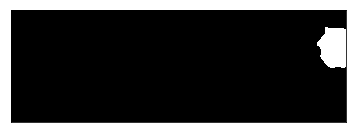

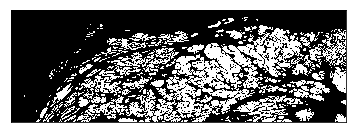

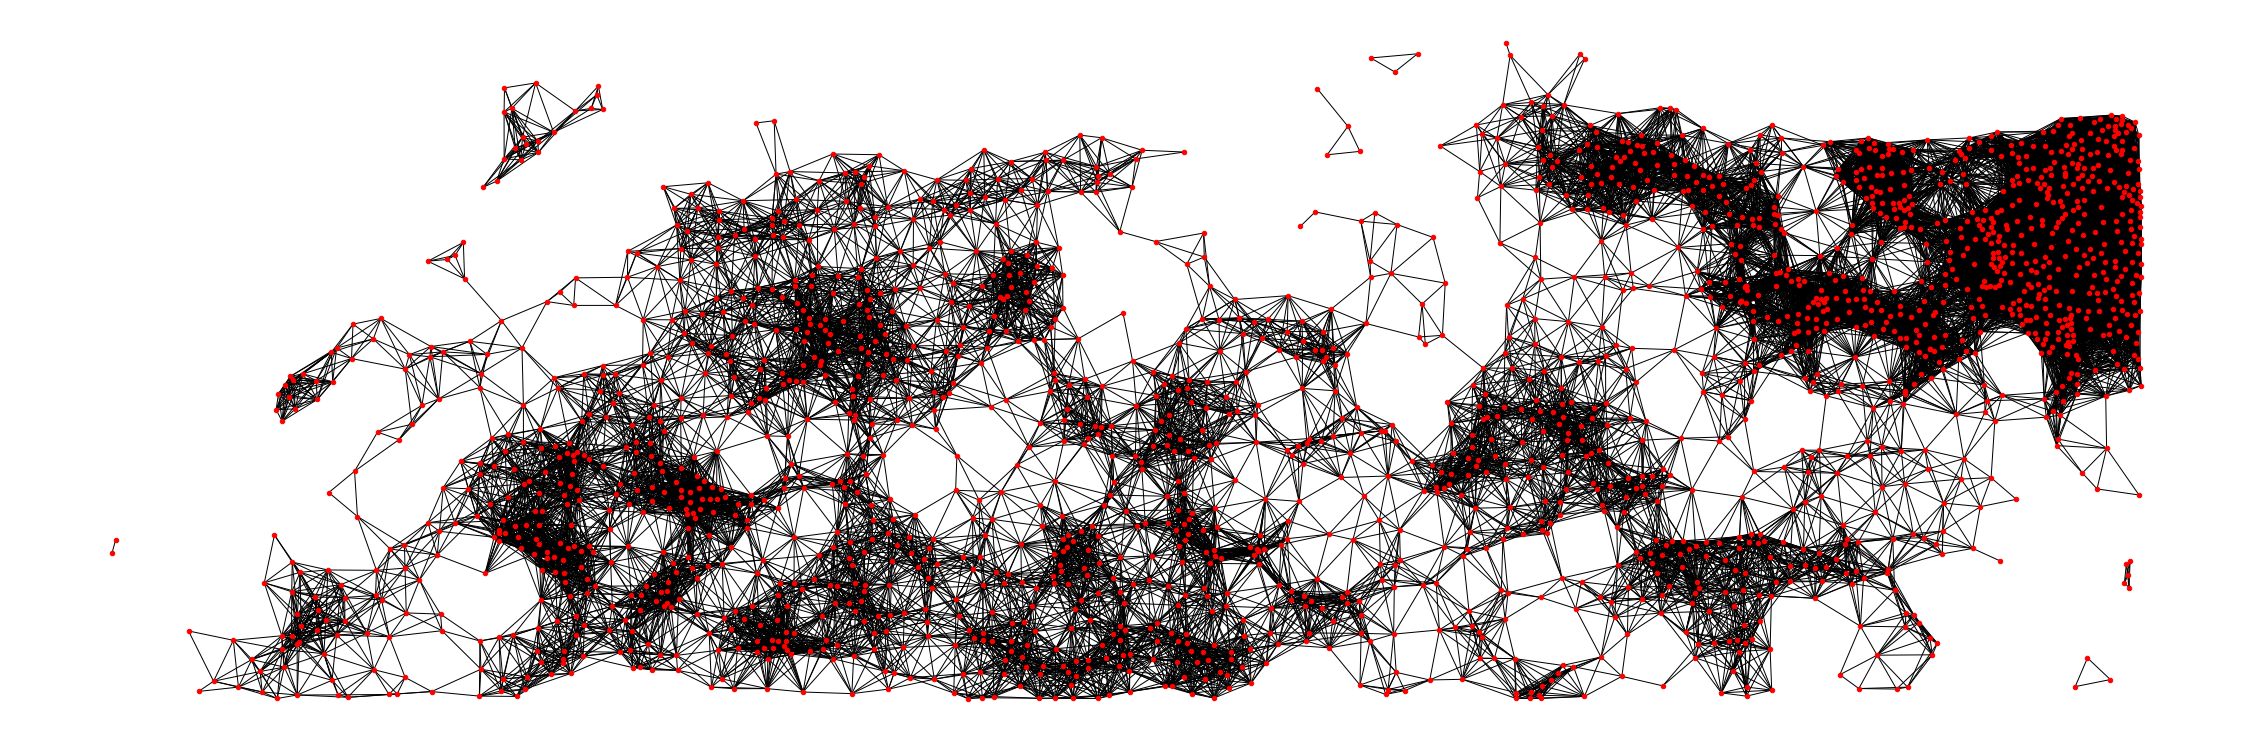

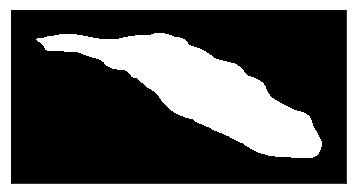

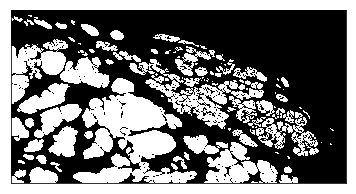

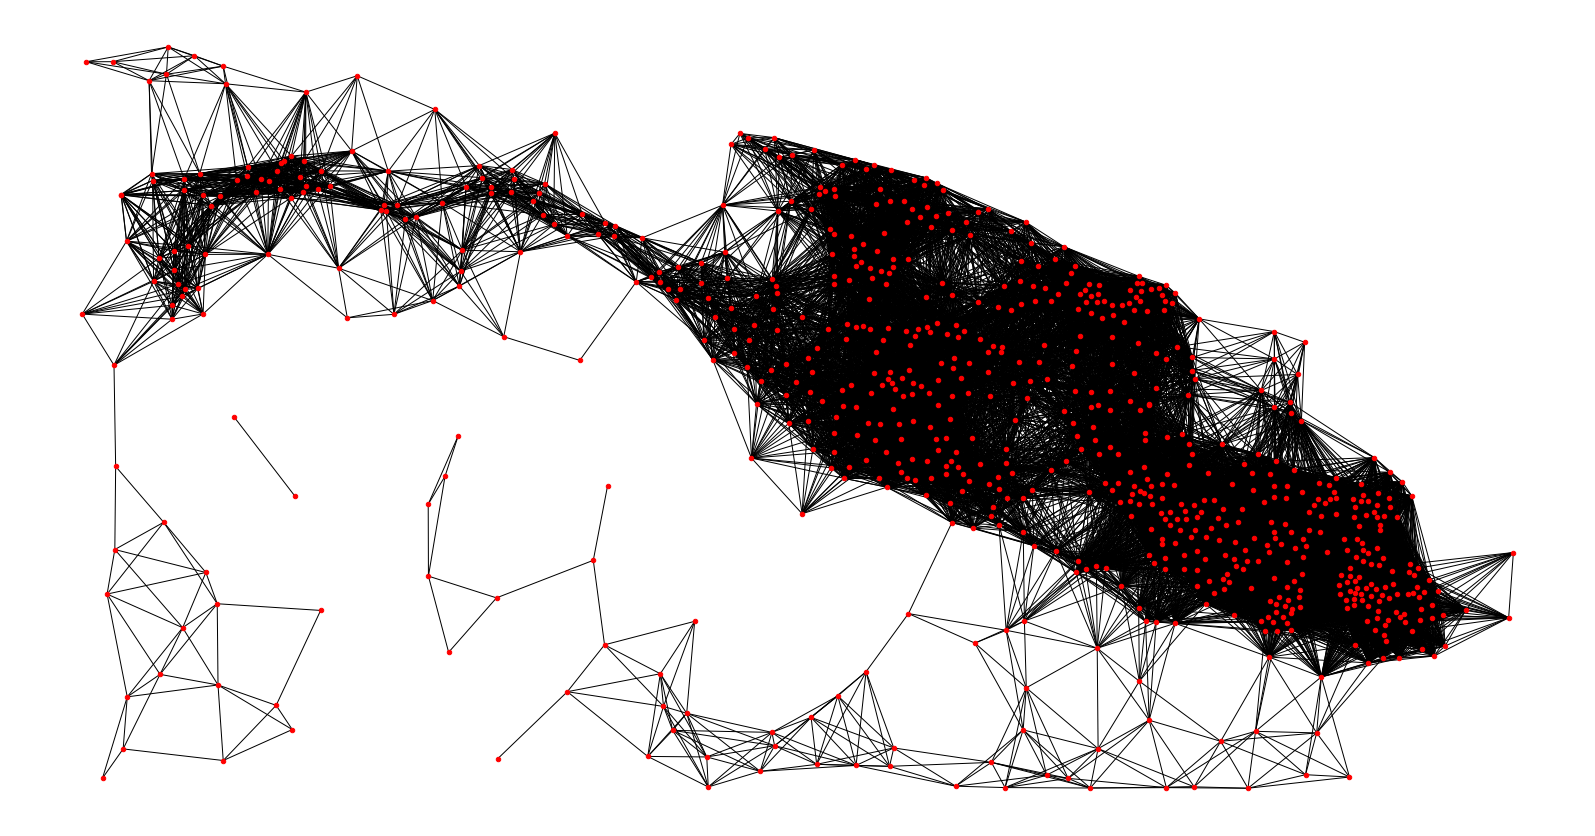

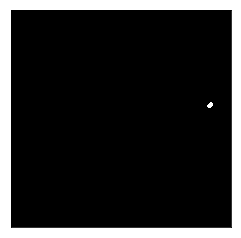

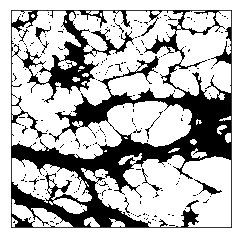

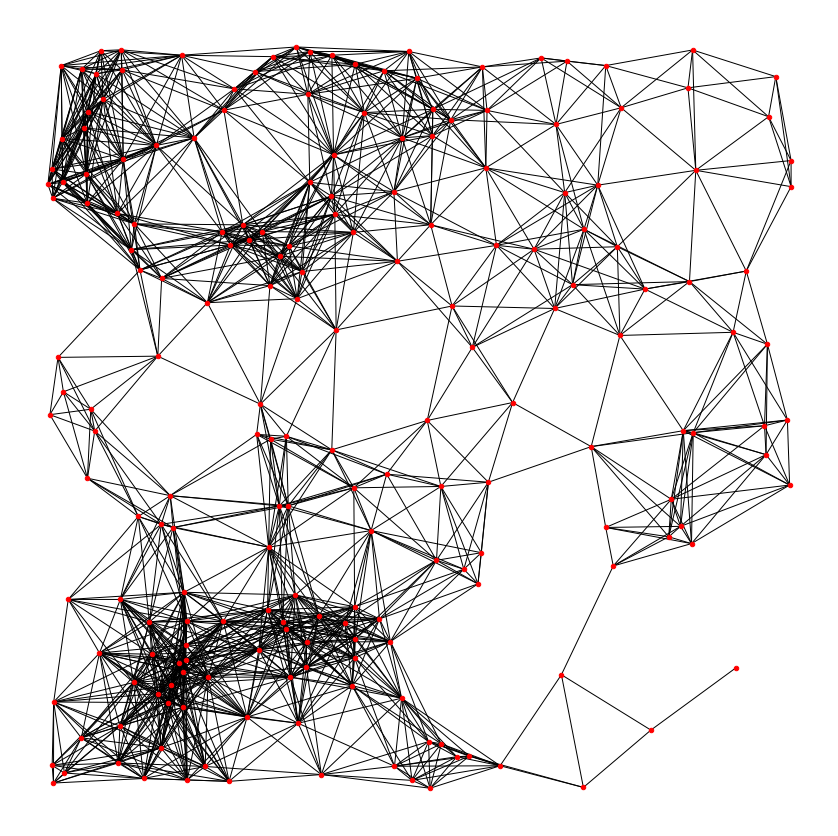

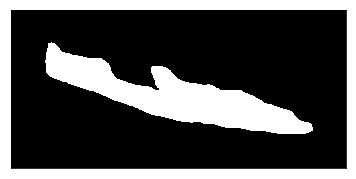

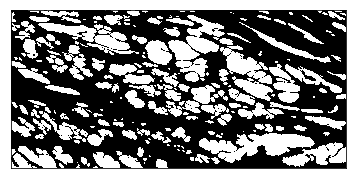

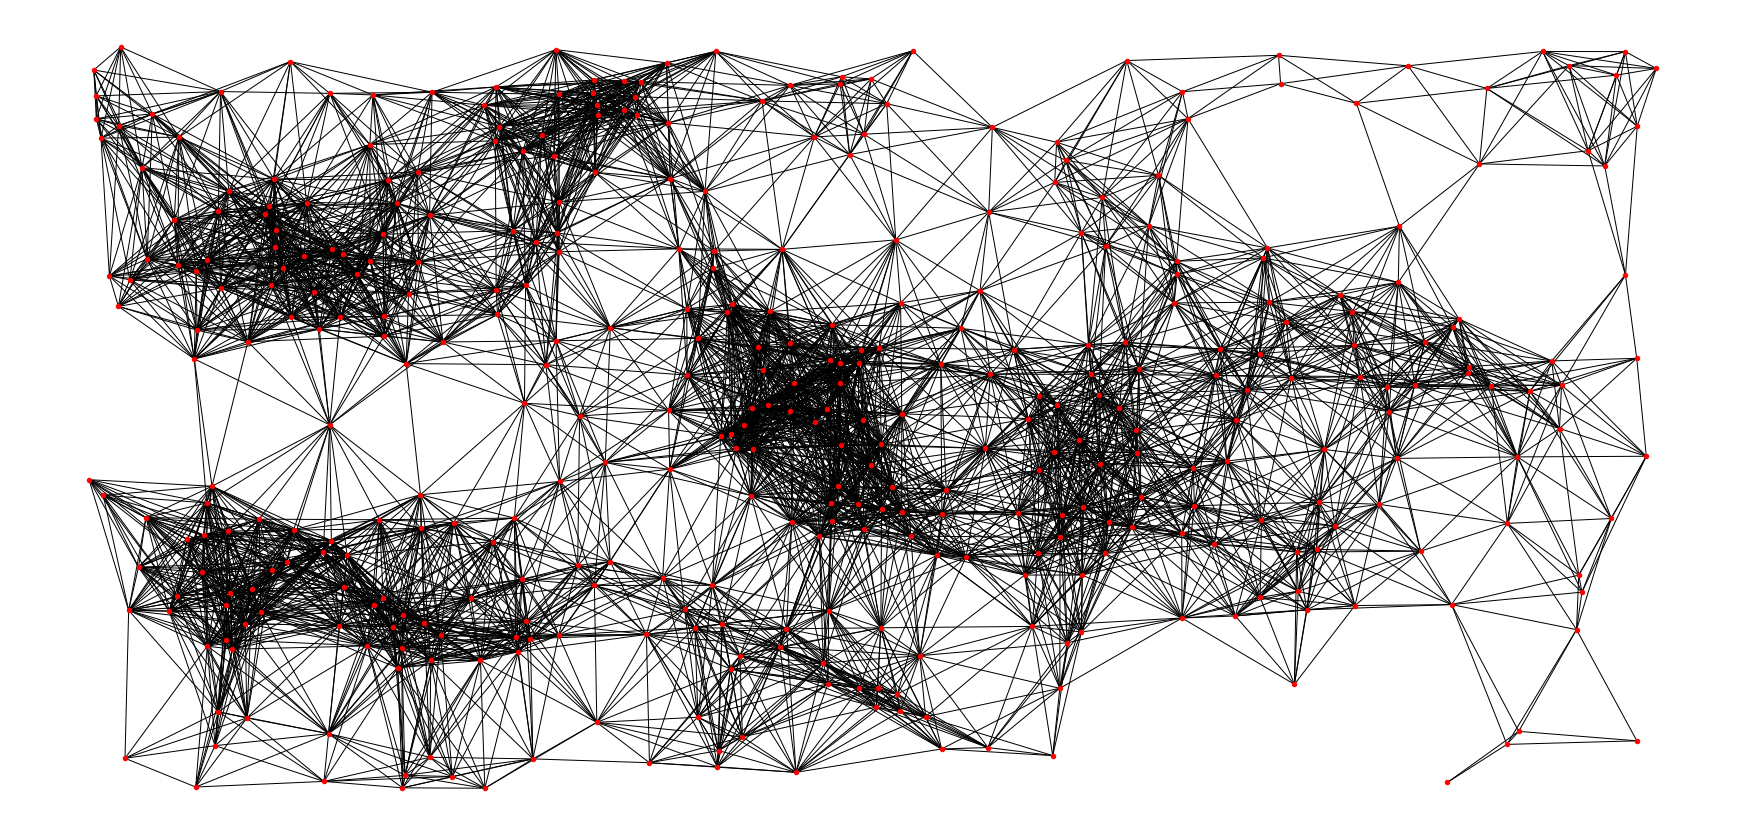

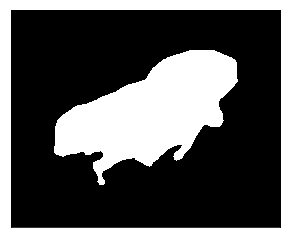

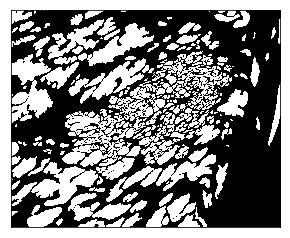

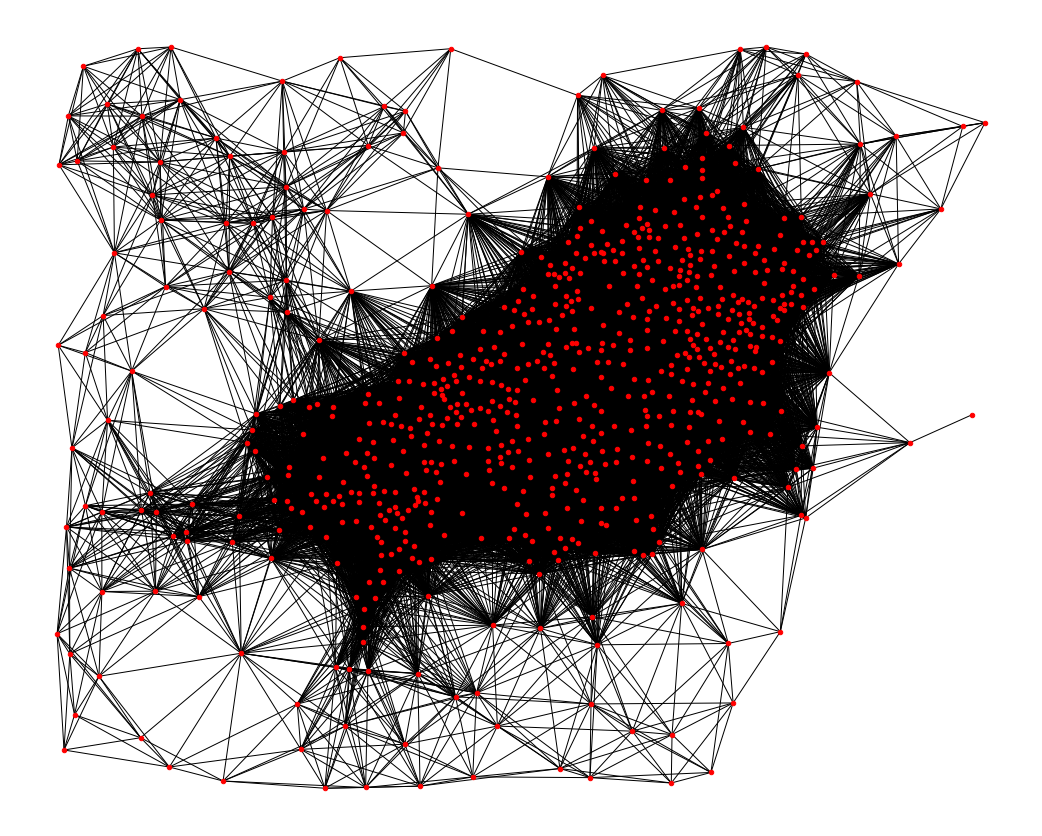

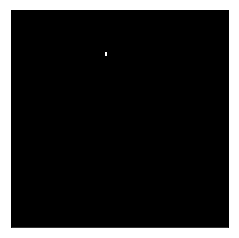

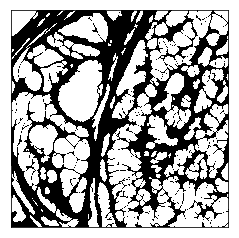

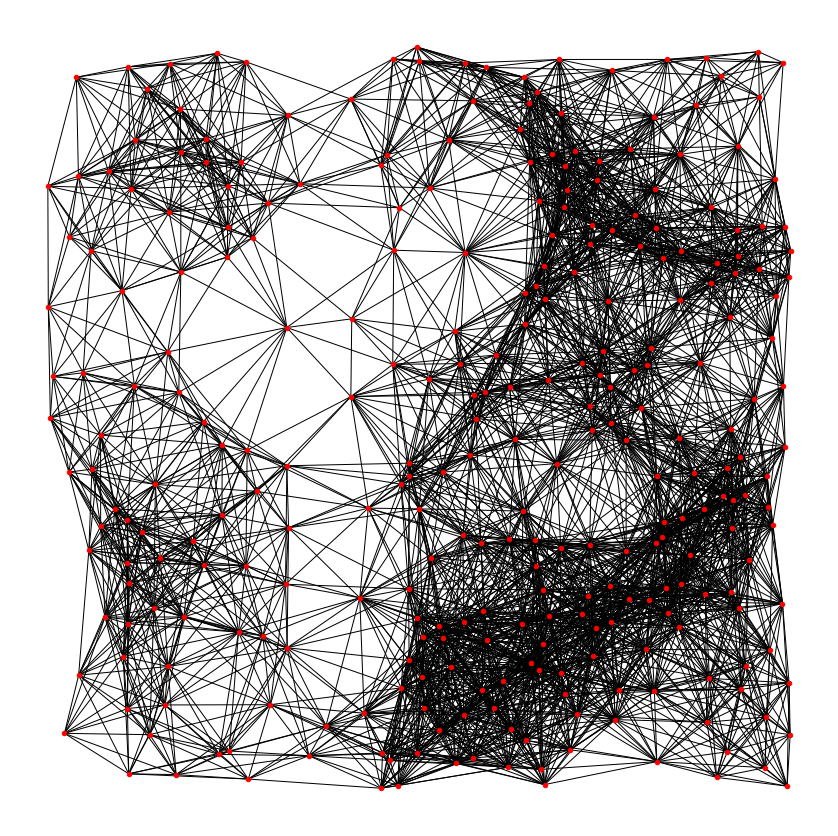

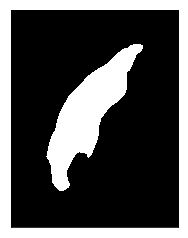

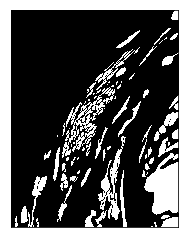

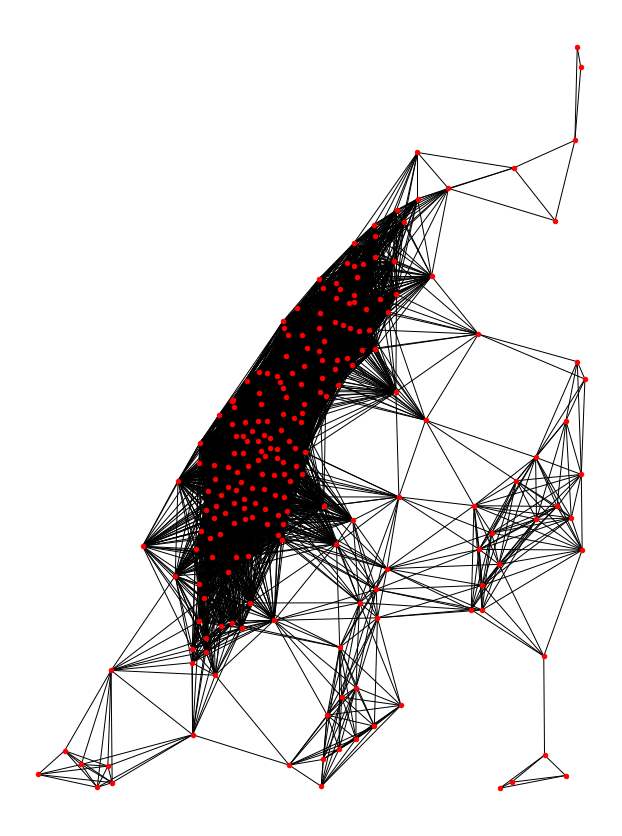

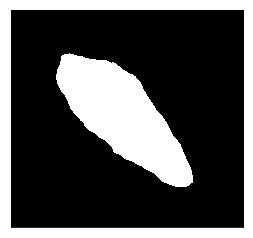

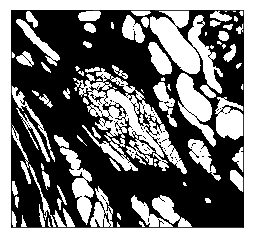

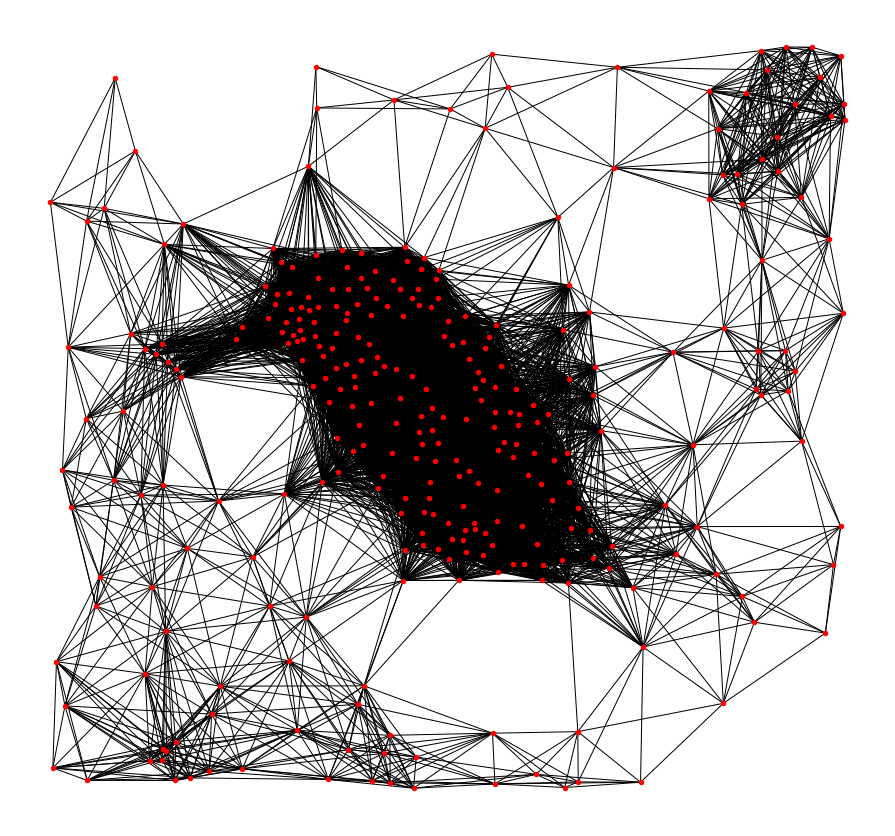

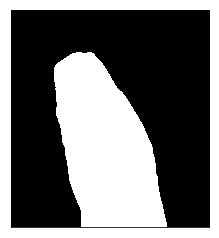

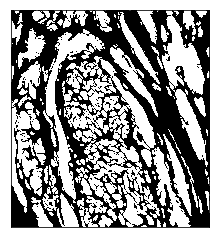

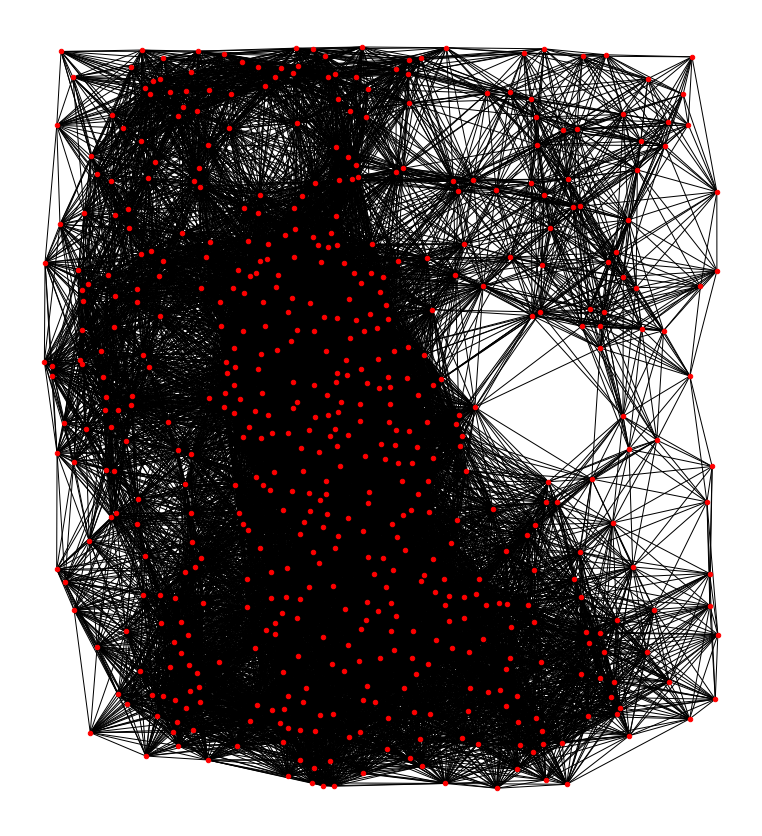

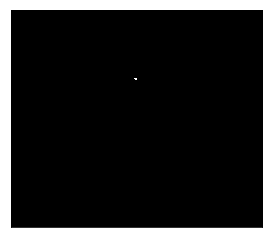

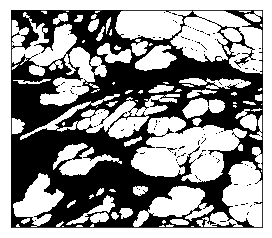

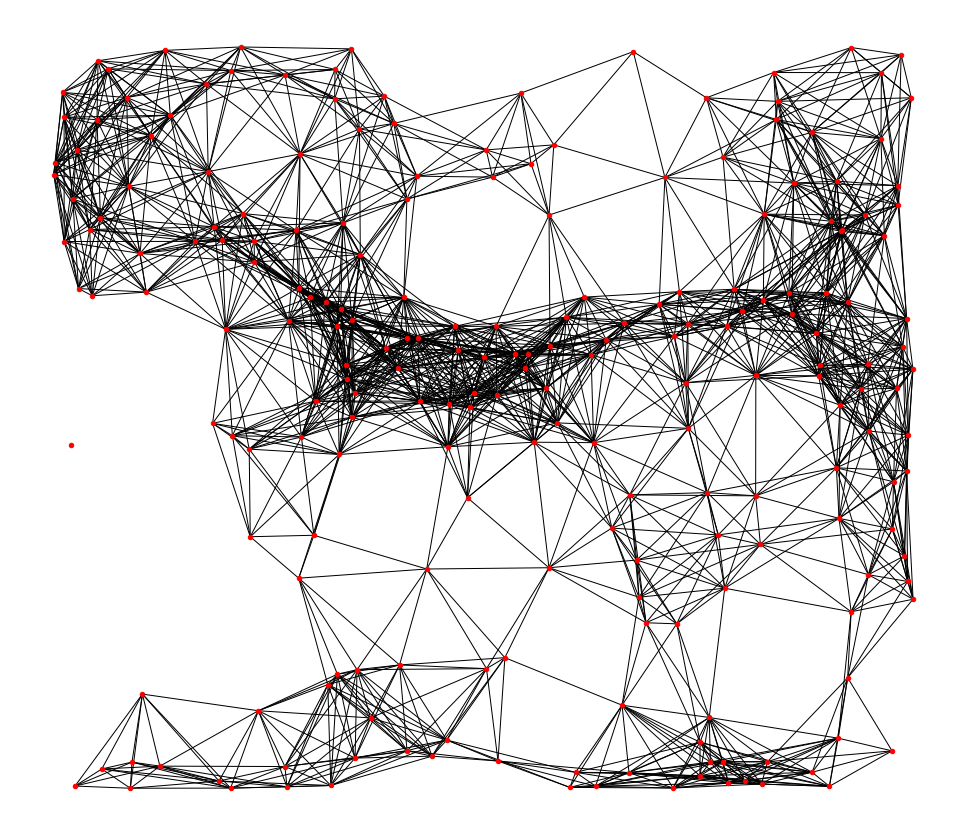

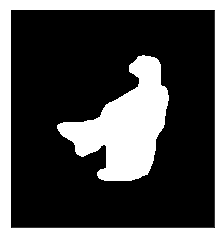

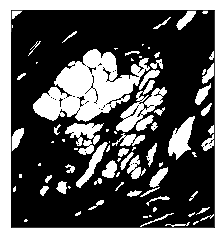

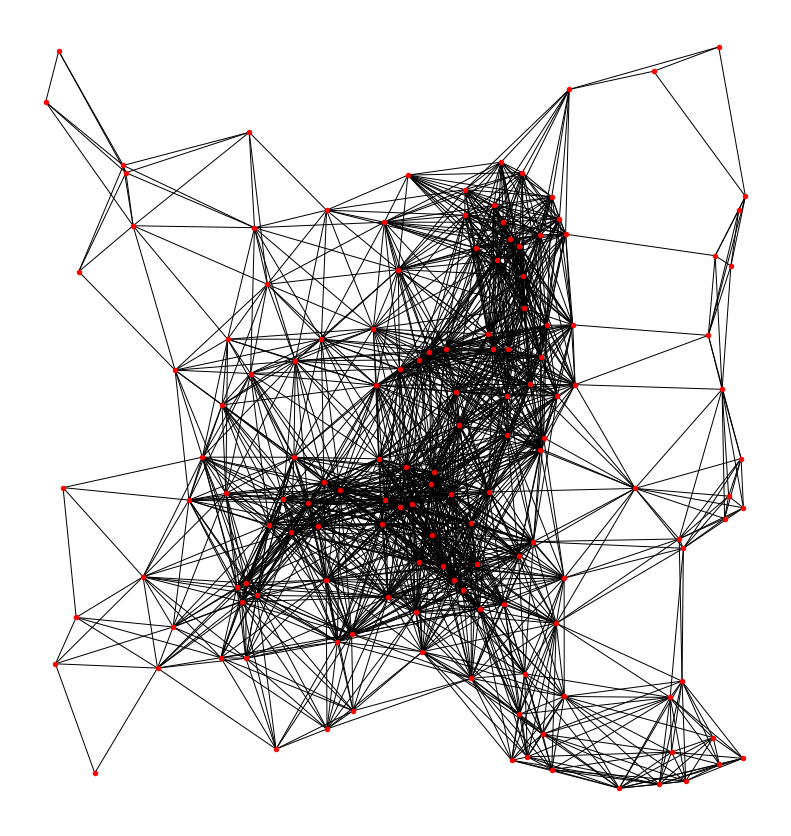

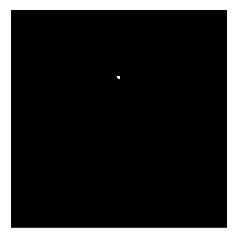

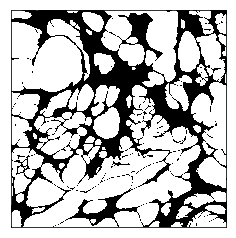

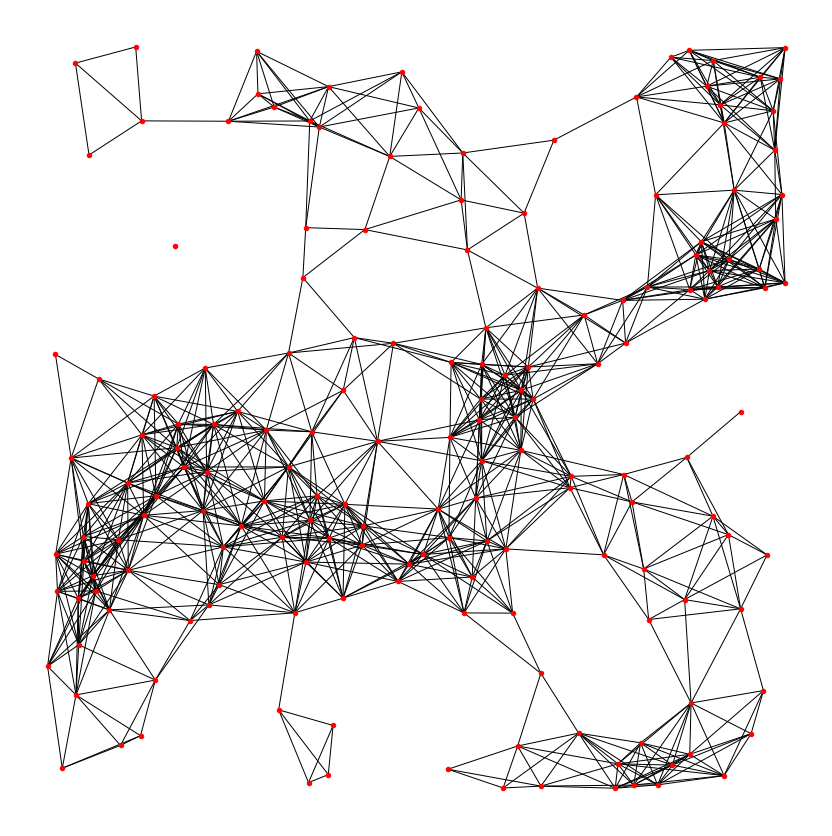

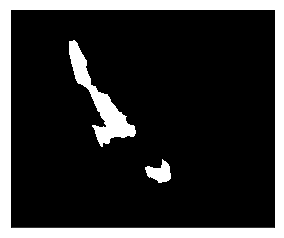

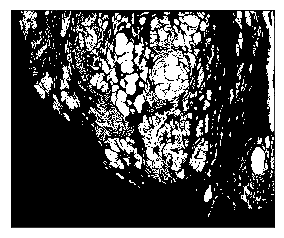

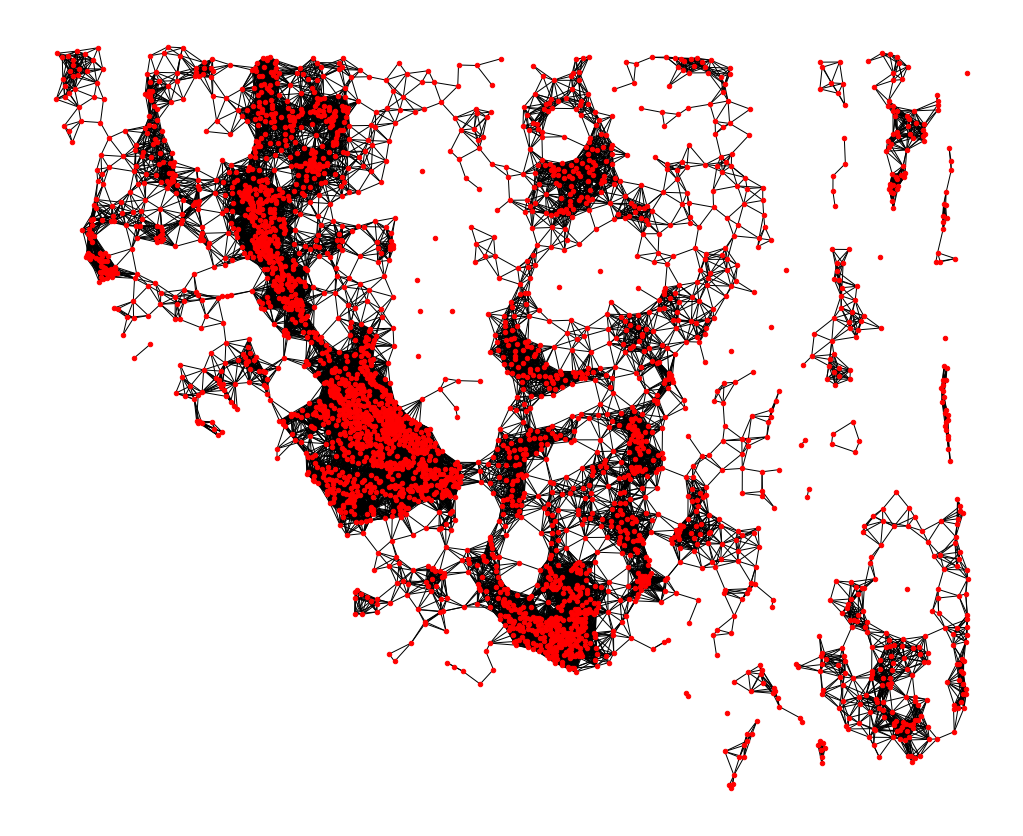

In [5]:
pos_path = 0

for idx, root_img_path in enumerate(article_rev1_root_img_path):
    result_path = root_img_path + '/results_radius_' + str(radius)
    
    img_path = root_img_path + '/IMG.jpg'
    img_mask_path = root_img_path + '/MASK.jpg'
    img_expert_demarcation_path = root_img_path + '/CA MASK.jpg'
    
    img = io.imread(img_path)
    img_mask = io.imread(img_mask_path)
    img_mask = misc.mask_correction(img_mask)
    expert_demarcation = io.imread(img_expert_demarcation_path)
    expert_demarcation = misc.mask_correction(expert_demarcation)
    
    misc.show_img(expert_demarcation)
    misc.show_img(img_mask)
    
    img_label, n = ndi.label(img_mask)
    img_expert_label, n_expert = ndi.label(expert_demarcation)
    print('Glands: ' + str(n) + ' - Region Demarcated: ' + str(n_expert))

    if not((img.shape[0], img.shape[1]) == img_mask.shape == expert_demarcation.shape):
        raise Exception('Images must have the same size')
    
    shape_props, props = prop.get_shape_props_from_mask(img_mask, shape_props_to_measure, return_scikit_props=True)
    
    g, points = geometric_graph.network_from_mask(img_mask, radius)
    nxgraph = misc.igraph_to_nx(g)
    g.vs['pos'] = points.tolist()

    fig = plt.figure(figsize=(40,15))
    ax = plt.subplot(111, aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    
    draw.draw_networkx(nxgraph, points, node_size=20, with_labels=False, edge_alpha=edge_alpha)

    nxgraph = misc.igraph_to_nx(g)
    nx.write_gml(nxgraph, result_path + "/grafo_" + str(radius) + "r.gml")
    plt.savefig(result_path + "/grafo_" + str(radius) + "r.png")
    
    
    ###############
    #Network Properties
    pos_nodes = g.vs["pos"]
    
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=None, normalize_pos=True, 
                                            normalize_att=True, alpha=alpha)

    nx.set_edge_attributes(nxgraph, weight_dict, 'weight')
    net_props = prop.get_graph_props(nxgraph)

    gland_properties  = []
    count = 0

    for idx in range(len(shape_props)):
        position = list(map(int, props[idx].centroid))
        
        obj = gland_property(_id = count, _row=int(position[0]), _column=int(position[1]), _demarcated=(expert_demarcation[position[0]][position[1]]==255), _area=shape_props[idx][0], _solidity=shape_props[idx][1], _eccentricity=shape_props[idx][2], _equivalent_diameter=shape_props[idx][3], _perimeter=shape_props[idx][4], _degree=net_props[idx][0], _strength=net_props[idx][1], _betweenness=net_props[idx][2])
        gland_properties.append(obj)
        
        count = count + 1

    demarcated_quantity_ = [(t.row[0],t.column[0]) for t in gland_properties if t.demarcated == True]
    print('Glands in Demarcated Area: ' + str(len(demarcated_quantity_)))        

    with open(result_path + '/glands_properties_' + str(radius) +'r.txt', 'w') as f:
        f.write('idx, row, column, demarcated, area, solidity, eccentricity, equivalent_diameter, perimeter, degree, strength, betweenness\n')
        for item in gland_properties:
            f.write("%d, %d, %d, %s, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f\n" % (item.id[0], item.row[0], item.column[0], item.demarcated, item.area[0], item.solidity[0], item.eccentricity[0], item.equivalent_diameter[0], item.perimeter[0], item.degree, item.strength, item.betweenness))

    nxgraph_properties = nxgraph = nx.Graph(nxgraph)

    id_dict = {}
    row_dict = {}
    column_dict = {}
    demarcated_dict ={}
    area_dict = {}
    solidity_dict = {}
    eccentricity_dict = {}
    equivalent_diameter_dict = {}
    perimeter_dict = {}
    degree_dict = {}
    strength_dict = {}
    betweenness_dict = {}

    for t in gland_properties:
        id_dict[t.id[0]] = t.id[0]
        row_dict[t.id[0]] = t.row[0]
        column_dict[t.id[0]] = t.column[0]
        demarcated_dict[t.id[0]] = str(t.demarcated)
        area_dict[t.id[0]] = t.area[0]
        solidity_dict[t.id[0]] = t.solidity[0]
        eccentricity_dict[t.id[0]] = t.eccentricity[0]
        equivalent_diameter_dict[t.id[0]] = t.equivalent_diameter[0]
        perimeter_dict[t.id[0]] = t.perimeter[0]
        degree_dict[t.id[0]] = t.degree
        strength_dict[t.id[0]] = t.strength
        betweenness_dict[t.id[0]] = t.betweenness
    
    nx.set_node_attributes(nxgraph, id_dict, 'idx')
    nx.set_node_attributes(nxgraph, row_dict, 'row')
    nx.set_node_attributes(nxgraph, column_dict, 'column')
    nx.set_node_attributes(nxgraph, demarcated_dict, 'demarcated')
    nx.set_node_attributes(nxgraph, area_dict, 'area')
    nx.set_node_attributes(nxgraph, solidity_dict, 'solidity')
    nx.set_node_attributes(nxgraph, eccentricity_dict, 'eccentricity')
    nx.set_node_attributes(nxgraph, equivalent_diameter_dict, 'diameter')
    nx.set_node_attributes(nxgraph, perimeter_dict, 'perimeter')
    nx.set_node_attributes(nxgraph, degree_dict, 'degree')
    nx.set_node_attributes(nxgraph, strength_dict, 'strength')
    nx.set_node_attributes(nxgraph, betweenness_dict, 'betweenness')

    nx.write_gml(nxgraph_properties, result_path + "/grafo_glands_properties_" + str(radius) + "r.gml")

    ###############
    
    pos_path += 1